# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 2 people, the notebook should be named:
12301230_3434343_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Meifang Li"
NAME2 = "Alex Labro"
EMAIL = "meifang.li@student.uva.nl"
EMAIL2 = "alex.labro@student.uva.nl"

# Lab 2: Classification

### Machine Learning 1, September/October 2021

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Do not delete/add cells. Also do not change the number of arguments in the given code.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct.
* Do not delete add new cells to your solution. Also do not change the number of arguments in the given methods.
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

**IMPORTANT: Note that for this coding exercise we are using flipped notation (denominator layout) for the gradient and the derivations.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

Reference materials for this assignment:
- Bishop's book Section 4.3 (4.3.1-4.3.4) for the logistic regression and Section 5.1-5.3 for the Neural Networks
- Erik's Lecture 6.4 for logistic regression and 8.1-8.5 for Neural Networks.

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

You have a friend with one big problem which needs your help: Your friend wants to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data

try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

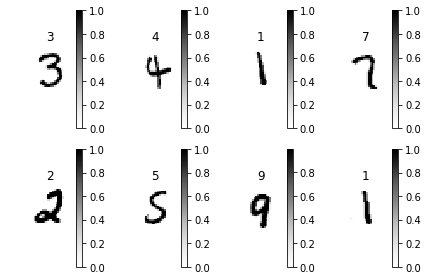

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{1}{Z} * \exp(\log q_j)
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 0 - \frac{1}{Z} * \exp(\log q_j)
\end{align}
YOUR ANSWER HERE

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

YOUR ANSWER HERE

$\frac{\partial \log q_j}{\partial W_{ij}}=x_i$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q x_i
$

so in vector form, we can get:

$\nabla_{\bw_j} \mathcal{L}^{(n)} = \mathbf{\delta}_j^q \mathbf x^T $

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    log_q = x @ w + b
    Z = np.sum(np.exp(log_q))
    # Calculate log z using log-sum-exp trick
    a = np.max(log_q)
    log_Z = a  + np.log(np.sum(np.exp(log_q - a)))
    log_p = log_q - log_Z
    
    # Define tn as a zero vector except on tn[t], which is 1
    tn = np.zeros(10)
    tn[t] = 1
    delta_q = tn - 1/Z * np.exp(log_q)
    # Calculate return parameters
    logp = log_p
    dL_dw = x.T @ delta_q
    dL_db = delta_q
    # here the statement contains logp[:,t] where logp is meant as a matrix of shape 1x10
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.36129469739e-07
Finite difference error grad_b: 5.23511749511e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    lr = 1e-4
    # Randomize training set
    random_order = np.random.permutation(len(x_train))
    x_random, t_random = x_train[random_order], t_train[random_order]
    logp_vector = np.zeros(len(x_random))
    t_vector = np.zeros(len(t_random))
    # Calculate gradients and logp
    for i in range(len(x_random)):
        # Calculate gradients for one datapoint
        datapoint = x_random[i:i+1:,]
        label = t_random[i:i+1]
        logp_train, dl_dw, dl_db = logreg_gradient(datapoint, label, W, b)
        # Update weights using gradients
        W += lr * dl_dw
        b += lr * dl_db
        index = random_order[i]
        logp_vector[index] = logp_train
    return logp_vector, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

diff:1.2165844088847224, iteration: 0
diff:0.5610652720114305, iteration: 1
diff:0.13628447939825372, iteration: 2
diff:0.07042825506856532, iteration: 3
diff:0.04460433316148983, iteration: 4
diff:0.03296044695836572, iteration: 5
diff:0.02609470390473587, iteration: 6
diff:0.021312051071977593, iteration: 7
diff:0.018028068786437583, iteration: 8


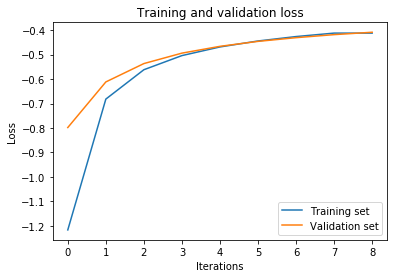

In [14]:
def test_sgd(x_train, t_train, x_valid, t_valid, W, b):
    # Initialize error as 0
    log_p_prev = 0
    log_p_list = []
    log_p_val_list = []
    for i in range(15):
        # Calclulate new parameters by SGD
        log_p, W_new, b_new = sgd_iter(x_train, t_train, W,  b)
        
        W = W_new
        b = b_new
        # validate with new parameters
        log_p_val = 0
        for j in range(len(x_valid)):
            log_p_vali, _ , _ =  logreg_gradient(x_valid[j:j+1:,], t_valid[j:j+1], W, b)
            log_p_val += log_p_vali
        log_p_val /= len(x_valid)
        
        diff = np.mean(np.abs(log_p_prev - log_p))
        print("diff:{}, iteration: {}".format(diff, i))
        # Terminate when close to converging (when change is small)
        if diff < 0.02:
            x_range = range(i+1)
            log_p_list.append(np.mean(log_p_prev))
            log_p_val_list.append(np.mean(log_p_val))
            break
        
        # Add to lists for plotting
        log_p_list.append(np.mean(log_p))
        log_p_prev = log_p
        log_p_val_list.append(np.mean(log_p_val))
        
    plt.plot(x_range, log_p_list, label="Training set")
    plt.plot(x_range, log_p_val_list, label="Validation set")
    plt.title("Training and validation loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    
    return W_new, b_new
    
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


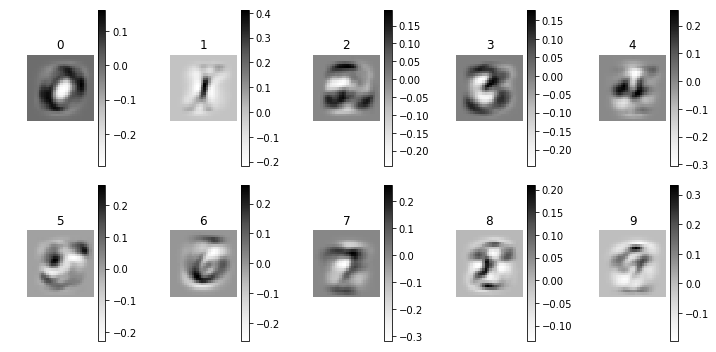

In [16]:
def plot_digits_w(W, targets=None, shape=(28,28)):
    num_digits = 10
    num_cols = 5
    num_rows = int(num_digits/num_cols)
    plt.figure(figsize=(10,5))
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(W[:,i].reshape(shape), interpolation='none', cmap='Greys')
        plt.title(str(i))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_digits_w(w,5)

**Describe in less than 100 words why these weights minimize the loss**
### Answer:
These weights minimize the loss by calculating the conditional probability of the label given the input image. These weights consist of features with a high probability of occuring in a certain digit. Thus, when the input image looks similar to one of the weights, the conditional probability will be relatively high for one digit class. The digit class with the highest probability will become the classification label of the input image, thus minimizing the loss between input and label.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


8 highest probabilities


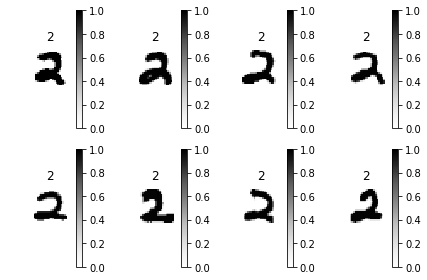

8 lowest probabilities


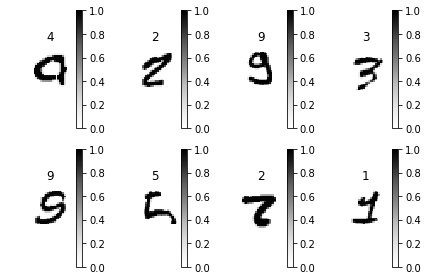

In [17]:
log_p=[]
for j in np.arange(len(x_valid)):
    log_p_val, _ , _ =  logreg_gradient(x_valid[j:j+1:,], t_valid[j:j+1], w, b)
    log_p.append(log_p_val)
# Plot 8 highest values
high_indices =  (- np.array(log_p)).argsort()[:8]
print("8 highest probabilities")
plot_digits(x_valid[high_indices], num_cols=4, targets=t_valid[high_indices])
# # Plot 8 lowest values
print("8 lowest probabilities")
low_indices = (np.array(log_p)).argsort()[:8]
plot_digits(x_valid[low_indices], num_cols=4, targets=t_valid[low_indices])

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

### Answer
These results make sense, since the digits with the lowest probabilities also take some effort for a human to classify. A digit is said to be hard to classify when it significantly deviates from the shape of that digit in W, which means it significantly differs from the way it is written in the rest of the dataset.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

### Answer
The likelihood of this function can be defined as $\log q_t^{(n)} - \log Z^{(n)} = (\bw^T_t\bh + b_t)^{(n)} - \log \sum_t q_t$

$\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier case because we can treat $\bh$ as $\bx$ in this formula. This leads to $\nabla_{\bb} \mathcal{L}^{(n)} = \mathbf{\delta}^q$ and $\nabla_{\bw_j} \mathcal{L}^{(n)} =  \delta^q_j  \bh^T$

$
\mathbf{\delta}_j^{h} = 
\frac{\partial \mathcal{L}^{(n)}}{\partial h_j}=
\sum_{k=1}^{n} \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k}\frac{\partial \log q_k}{\partial h_j}
=
\sum_{k=1}^{n} \delta^q_k 
\frac{\partial (\bw_k^T \bh + b_k)}{\partial h_k}=
\sum_{k=1}^{n} \delta^q_k w_{jk}
$

so we can get $\mathbf{\delta}^h = \mathbf{\delta}^q \bw^T$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \bw_j^T \bh + b_j}{\partial W_{ij}}
=\mathbf{\delta}_j^q h_{i}
$

$\frac{\partial\mathcal{L}^{(n)}}{\partial a_j} = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j} \frac{\partial h_j}{\partial a_j} = \delta^h_j  h_j(1-h_j)$ ,according to $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.


$\frac{\partial\mathcal{L}^{(n)}}{\partial V_{ij}}=\frac{\partial \mathcal{L}^{(n)}}{\partial h_j}  \frac{\partial h_j}{\partial V_{ij}} = \mathbf{\delta}_j^h h_j(1-h_j) \frac{\partial (\bv_j^T \bx + a_j)}{\partial V_{ij}}
= \mathbf{\delta}_j^h h_j(1-h_j) x_i 
$
,according to $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

### Answer
Maximum a posteriori is normally calculated by maximizing the log posterior. In this case the maximum a posteriori can be calculated by multiplying the MLP solution with the maximized log prior. This provides us with the formula for the MAP, which can be solved for the desired parameters by setting it to zero. 

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [18]:
def mlp_forward(x,W,b,V,a):
    """
    performs forward propagation to compute log_p
    """
    # compute activation
    activ = x @ V + a
    # compute sigmoid
    h = 1 / (1 + np.exp(-activ))
    # compute logq and logZ
    logq = h @ W + b
    logq_max = np.max(logq)
    logZ = logq_max  + np.log(np.sum(np.exp(logq - logq_max)))
    logp = logq - logZ
    
    return logp, h

    
def mlp_backward(x,W,b,V,a,h,t,logp):
    # Calculate delta_q
    delta_q = -np.exp(logp)
    delta_q[0, np.array(t, dtype=np.int32)] += 1
    
    # Calculate delta_h
    delta_h = delta_q @ W.T
    
    # Calculate gradients
    dL_db = delta_q
    dL_dW = h.T @ delta_q
    dL_da = delta_h * h * (1-h)
    dL_dV = x.T @ dL_da
    
    return dL_db, dL_dW, dL_da, dL_dV

def mlp_sgd_iter(x, t, W, b, V, a, lr,backward=True):
    # Shuffle dataset
    random_order = np.random.permutation(len(x))
    x_random, t_random = x[random_order], t[random_order]
    logp_mean = 0
    
    # Calculate gradients and logp
    for i in range(len(x_random)):
        # Calculate gradients for one datapoint
        datapoint = x_random[i:i+1:,]
        label = t_random[i:i+1]
        logp, h = mlp_forward(datapoint,W,b,V,a)
        if backward:
            dL_db, dL_dW, dL_da, dL_dV= mlp_backward(datapoint,W,b,V,a,h,label,logp)
            # Update weights
            b += lr * np.reshape(dL_db,-1)
            W += lr * dL_dW
            a += lr * np.reshape(dL_da, -1)
            V += lr * dL_dV
        logp_mean += np.mean(logp[:,label])
        
    logp_mean = logp_mean/len(x)
    return logp_mean, b, W, a, V

In [19]:
# Hidden tests for efficiency

In [20]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

# YOUR CODE HERE
def mlp_train(x_train, t_train, x_valid, t_valid, b,W,a,V, epochs, lr):
    # Initialize lists for plotting
    logp_list = []
    logp_val_list = []
    weight_list = []
    
    for epoch in range(epochs):
        # Update parameters through SGD, calculate loss
        logp, b, W, a, V = mlp_sgd_iter(x_train, t_train, W, b, V, a, lr, backward=True)
        if epoch in [0, 4, 9]:
            weight_list.append(V.copy())
            
        logp_list.append(logp)
        print("Epoch {}: {}".format(epoch, logp))
        
        logp_val, _,_,_,_= mlp_sgd_iter(x_valid, t_valid, W, b, V, a, lr, backward=False)
        logp_val_list.append(logp_val)
    
    return logp_list, logp_val_list, weight_list

Model training for learning rate: 0.01
Epoch 0: -0.5016539272994285
Epoch 1: -0.24653550657681403
Epoch 2: -0.20739884376159934
Epoch 3: -0.18509199335025114
Epoch 4: -0.16958626900692997
Epoch 5: -0.1582132322477715
Epoch 6: -0.14918693823599474
Epoch 7: -0.14025643223095288
Epoch 8: -0.13370469726248788
Epoch 9: -0.12802402922078984
Model training for learning rate: 0.001
Epoch 0: -1.5025846261303315
Epoch 1: -0.6337221763772594
Epoch 2: -0.4485064153209495
Epoch 3: -0.3781784440270836
Epoch 4: -0.3407499240877808
Epoch 5: -0.31606573956207124
Epoch 6: -0.29786221267125407
Epoch 7: -0.28352912360969723
Epoch 8: -0.2719055291433834
Epoch 9: -0.2618583118370297
Model training for learning rate: 0.0001
Epoch 0: -2.267708863774181
Epoch 1: -2.163321105918489
Epoch 2: -2.0116718500099164
Epoch 3: -1.8144780197114505
Epoch 4: -1.6056092404028925
Epoch 5: -1.4146938208490645
Epoch 6: -1.2535859555031847
Epoch 7: -1.122257298147258
Epoch 8: -1.0160449637636093
Epoch 9: -0.9297727589009285


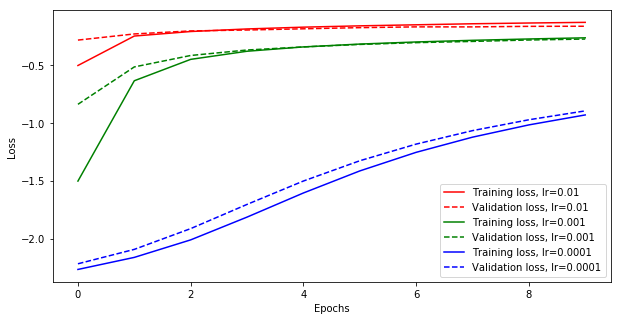

In [21]:
# plot the train and validation logp for all three learning rates in one figure

# YOUR CODE HERE

# 1 initialize parameters
n_layers = 20
np.random.seed(1243)

# 2 train model, get parameters
lr_list = [1e-2, 1e-3, 1e-4]
c_list = ["r", "g", "b"]
epoch_count = 10
weights_total = []

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
for i in range(len(lr_list)):
    
    b = np.random.normal(0,0.1, 10)
    W = np.random.normal(0,0.1,(n_layers,10))
    a = np.random.normal(0,0.1,n_layers)
    V = np.random.normal(0,0.1, (784, n_layers))
    
    learning_rate = lr_list[i]
    print("Model training for learning rate:", learning_rate)
    logp_list, logp_val_list, weights = mlp_train(x_train, t_train, x_valid, t_valid, b,W,a,V, epoch_count, learning_rate)
    weights_total.append(weights)
    # 3 plot values
    clr = c_list[i]
    plt.plot(range(epoch_count), logp_list, color=clr, label="Training loss, lr={}".format(learning_rate))
    plt.plot(range(epoch_count), logp_val_list, color=clr, linestyle ='dashed',label="Validation loss, lr={}".format(learning_rate))
    
plt.legend()
plt.show()

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

### Answer
The model with the biggest learning rate appears to be the most succesful in converging on the optimal parameters of the model. This indicates that other learning rates are too small and therefore take much longer to converge. The steps that the best model is making in each iteration is small enough to move in the correct direction, but also large enough that it converges in two steps. 

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

### Answer
The  weights differ because the output of the MLP is based on a combination of these weights, while logistic regression was simply applying the weights to an input. This means that the MLP has a higher performance, since it is not dependent on one set of weights, but rather a collection of weights.

Weights of epoch 0


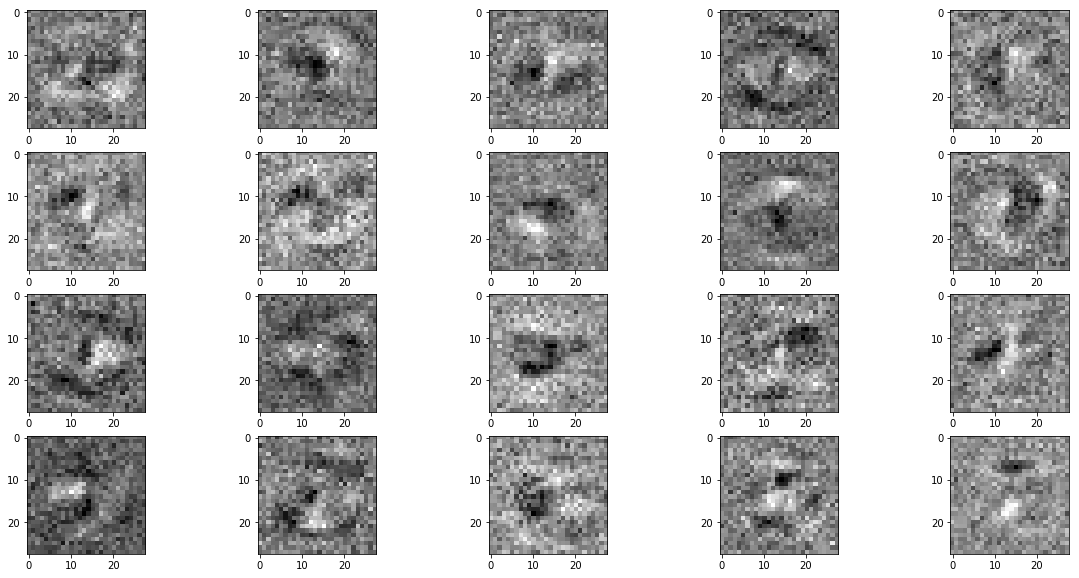

Weights of epoch 4


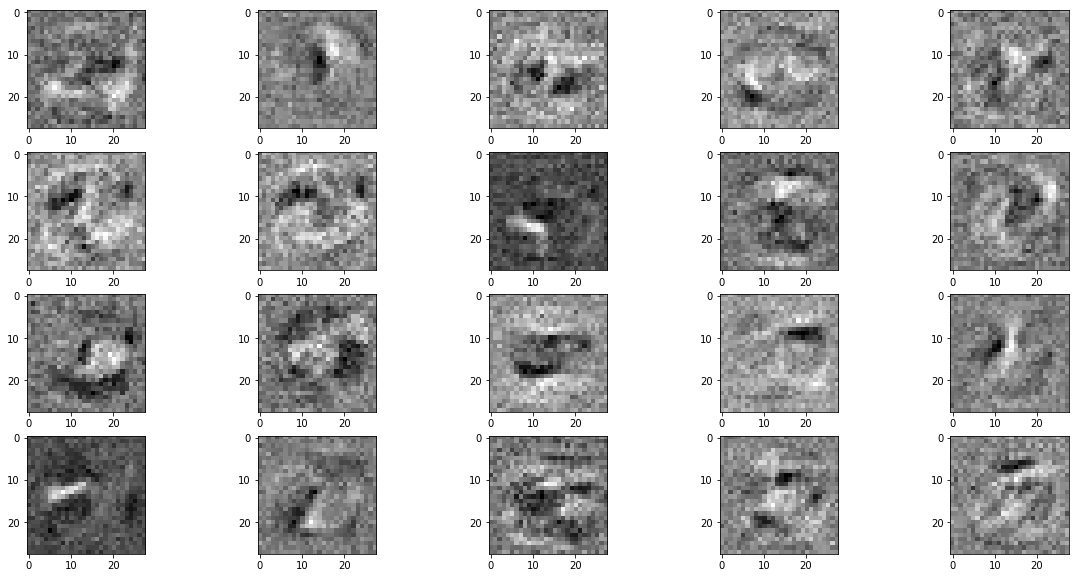

Weights of epoch 9


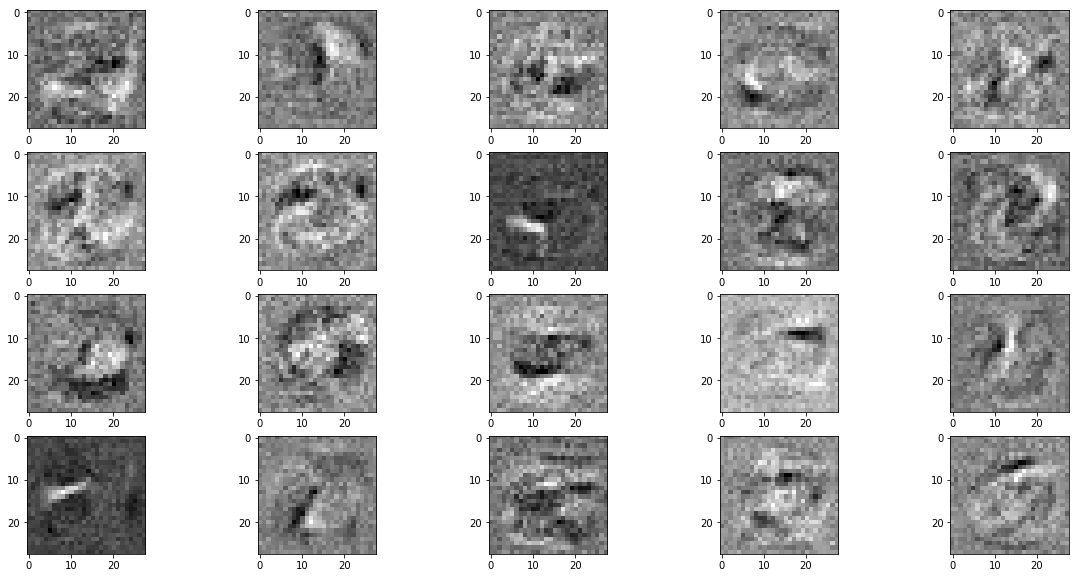

In [22]:
# Plot the weights of the first layer for the best model 

# The model with learning rate 0.01 seems to be the best: plot its weights
weights_best = np.array(weights_total[0])
def plot_weights_V(V):
    count = 0
    layers = [0,4,9]
    for i in weights_best:
        plt.figure(figsize=(20,10))
        print("Weights of epoch {}".format(layers[count]))
        for j in range(i.shape[1]):
            plt.subplot(4,5, j+1)
            plt.imshow(i[:,j].reshape(28,28), interpolation='none' ,cmap="gray")
        plt.show()
        count+=1
plot_weights_V(weights_best)

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:
### Answer

ReLU: $\frac{\partial}{\partial x} ReLU(x) = \frac{\partial}{\partial x}max(0.,x) = \begin{equation}
f(x)=\begin{cases}
    0, & \text{if $x< 0$}.\\
    1, & \text{if $x > 0$}.
  \end{cases}
\end{equation}$

tanh: $\frac{\partial}{\partial x}tanh(x) = \frac{\partial}{\partial x}\frac{e^x - e^{-x}}{e^x  + e^{-x}} = \frac{(e^x+e^{-x})(e^x + e^{-x})- (e^x - e^{-x})(e^x-e^{-x})}{(e^x + e^{-x})^2} = 1 - \frac{(e^x - e^{-x})^2}{(e^x+e^{-x})^2} = 1 - tanh^2(x)$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

### Answer
An activation function must be symmetrical at zero, because otherwise the gradient descent will shift to one direction. What is also desirable of an activation function is easy computability, since the activation function will be calculated for every node for every datapoint which requires an easily computable function to be viable.

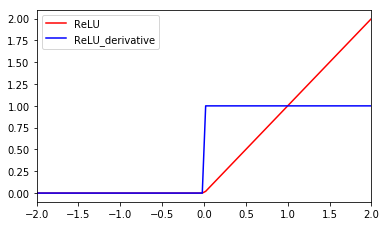

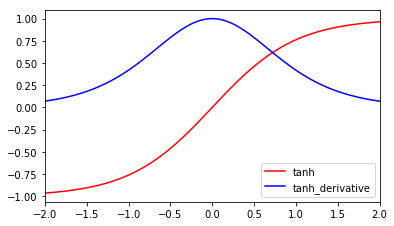

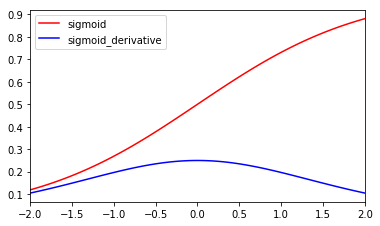

In [23]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

def ReLU(x):
    x[x<0]=0
    return x

def deriv_ReLU(x):
    x[x<0]=0
    x[x>0]=1
    return x

def tanh(x):
    return np.tanh(x)

def deriv_tanh(x):
    return 1-(np.tanh(x))**2

def sigmoid(x):
    return 1/(1+np.exp(-x))

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

x = np.linspace(-2,2,100)

plt.figure(figsize=(6,12))
plt.subplot(311)
plt.plot(x, ReLU(x.copy()), 'r', label="ReLU")
plt.plot(x, deriv_ReLU(x.copy()), 'b', label="ReLU_derivative")
plt.xlim(-2,2)
plt.legend()
plt.show()

plt.figure(figsize=(6,12))
plt.subplot(312)
plt.plot(x, tanh(x), 'r', label="tanh")
plt.plot(x, deriv_tanh(x), 'b', label="tanh_derivative")
plt.xlim(-2,2)
plt.legend()
plt.show()

plt.figure(figsize=(6,12))
plt.subplot(313)
plt.plot(x, sigmoid(x), 'r', label="sigmoid")
plt.plot(x, deriv_sigmoid(x), 'b', label="sigmoid_derivative")
plt.xlim(-2,2)
plt.legend()
plt.show()

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

### Answer
In opinion, the ReLU is the best activation function. This is because it is symmetrical at 0 and computed very easily. Although tanh is symmetrical at zero and sigmoid is relatively easy to compute, these activation functions do not penalize negative values as much as ReLU. This leads to quicker learning for sigmoid and tanh, but ultimately also to a lower performance in comparison to ReLU,.

In [24]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 6.6 minutes.
